# Imports
 All the necessary libraries are imported, they are used in building the model, plotting the confusion matrix, and more.

In [2]:
# necessary imports
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Activation Functions
- Relu is the activation function used during feed forward by the hidden layer, the output layer uses softmax.
- The derivative of relu is used during backpropagation to determine the loss.

In [3]:
# the ReLU activation function returns the input (x) if its positive otherwise it returns 0
def relu(x):
    return np.maximum(0, x)

# the derivative of the ReLU function returns 1 for positive inputs and 0 for non-positive inputs
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# the softmax function converts the scores (x) into probabilities
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Multi Layer Perceptron Model

This is model I have chosen for the training and testing of the datasets provided, it uses RMSProp as an optimizer and here is a breakdown of each function and its purpose: 

### 1) init
> Initialize the variables that will be used in other functions later down the line, this includes the number of input neurons (i), hidden layer sizes number of cycles, the number of output neurons (o), learning rate, dropout rate (to prevent overfitting), RMSProp optimizer variables, activation function with its derivative, the weights and biases for both hidden layers and the output. 

> A key concept applied is Kaiming He Initialization for weights, which is: $ N(0, \frac{2}{n}) $ where $n$ is number of inputs and $N$ refers to normal distribution.


### 2) initialize_rmsprop_variables  
> Initialize the RMSProp variables, which includes <b>decay_rate</b> (set to the standard of 0.9, used for the decay of the average of squared gradients) and <b>eps</b> (epsilon, set to 0.00000001 or 1e-08, used to prevent zero division error).

> The <b>avg_sq_wo</b> tracks the moving average of squared gradients for the output weights, <b>avg_sq_bo</b> for output biases, <b>avg_sq_wh1</b> for hidden weights of the first hidden layer, and <b>avg_sq_bh1</b> for biases of the first hidden layer,<b>avg_sq_wh2</b> for hidden weights of the second hidden layer, and <b>avg_sq_bh2</b> for biases of the second hidden layer.


### 3) update_rmsprop_variables
> It takes the gradients for the hidden and output weights and biases as arguments, and uses them to update the moving average of squared gradients for them, this is done using the RMSProp update rule which is: <br> $ v_t = γ * v_{t-1} + (1 - γ) * g_t^2 $ <br> where <b>$γ$</b> is the decay rate, <b>$g_t$</b> is the gradient.


### 4) get_accuracy
> Takes the predictions, actual targets and the shape (which is the total number of samples) and returns the accuracy between 0 and 1, 1 being complete accuracy.


### 5) feed_forward 
> Takes the X features as <b>X</b>, along with a boolean value for train which is used to determine whether dropout will be applied or not.

> If <b>train=True</b> then dropout is applied as a form of regularization to reduce overfitting.

> First matrix multiplication is performed between the inputs and the hidden weights of the first layer, to which the hidden bias of the first layer is added to avoid zeroes, and then its passed through the activation function which is relu.

> The output of the first hidden layer is passed as input to the second hidden layer, once again matrix multiplication performed and bias is added and the result is passed throught the relu activation again.

> The same process as before is done once more between the second hidden and output layer, the hidden outputs are multiplied with the output weights and the output biases are added to avoid zero, finally it is passed through the softmax function to return probabilities for each class, the sum of these are equal to 1.

### 6) backpropagation
> Takes the X features as <b>X</b>, target output as <b>y</b>, and predicted output as <b>output</b>.

> Calculate the output error by subtracting the true/target output from the predicted output, and use it to calculate the gradient of the loss for the output weights and output bias.

> Calculate the hidden error by propagating the output error backwards and using the derivative of the activation function (relu), use the hidden error to calculate the gradient of the loss for the hidden weights and biases.

> Update the RMSprop variables using the gradients calculated prior.

> Use the updated averages of squared gradients to update the weights and biases, the formula is: <br> $ θ_{t+1} = θ_t - α * \frac{g_t}{√v_t + ε}$ <br> where <b>$α$</b> is the learning rate, <b>$g_t$</b> is the gradient of the parameter, <b>$v_t$</b> is the average of squared gradients of the parameter and <b>$ε$</b> is epsilon (self.eps in the class).


### 7) train 
> Takes the X features as <b>X</b>, and target output as <b>y</b>.

> Goes through the specified number of cycles, during which it undergoes the feed forward and backpropagation processes using their respective functions, it then calculates the accuracy using the get_accuracy function and prints it every 10 cycles.


### 8) make_prediction
> Takes the X features as <b>X</b>, and provides the to the feed_forward function with train=False to avoid dropout, np.argmax is used on the result to find the index of the maximum value/probability in each of the rows, and is returned.


In [4]:
class MLP:
    def __init__(self, i, h1, h2, o, cycles, learning_rate=0.001, dropout_rate=0.5):
        self.cycles = cycles
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate

        # Kaiming He initialization for weights
        self.weights_hidden1 = np.random.randn(i, h1) * np.sqrt(2. / i)
        self.weights_hidden2 = np.random.randn(h1, h2) * np.sqrt(2. / h1)
        self.weights_output = np.random.randn(h2, o) * np.sqrt(2. / h2)

        # Bias initialization
        self.bias_hidden1 = np.zeros((1, h1))
        self.bias_hidden2 = np.zeros((1, h2))
        self.bias_output = np.zeros((1, o))

        # Initialize variables for RMSProp optimizer
        self.initialize_rmsprop_variables()

        # Assign activation function and its derivative
        self.activation_function, self.activation_derivative = relu, relu_derivative

    def initialize_rmsprop_variables(self):
        self.decay_rate = 0.9
        self.eps = 1e-08

        # Initialize moving averages of squared gradients
        self.avg_sq_wh1, self.avg_sq_bh1 = np.zeros_like(self.weights_hidden1), np.zeros_like(self.bias_hidden1)
        self.avg_sq_wh2, self.avg_sq_bh2 = np.zeros_like(self.weights_hidden2), np.zeros_like(self.bias_hidden2)
        self.avg_sq_wo, self.avg_sq_bo = np.zeros_like(self.weights_output), np.zeros_like(self.bias_output)

    def update_rmsprop_variables(self, wo_grad, bo_grad, wh1_grad, bh1_grad, wh2_grad, bh2_grad):
        self.avg_sq_wo = self.decay_rate * self.avg_sq_wo + (1 - self.decay_rate) * np.square(wo_grad)
        self.avg_sq_bo = self.decay_rate * self.avg_sq_bo + (1 - self.decay_rate) * np.square(bo_grad)
        self.avg_sq_wh1 = self.decay_rate * self.avg_sq_wh1 + (1 - self.decay_rate) * np.square(wh1_grad)
        self.avg_sq_bh1 = self.decay_rate * self.avg_sq_bh1 + (1 - self.decay_rate) * np.square(bh1_grad)
        self.avg_sq_wh2 = self.decay_rate * self.avg_sq_wh2 + (1 - self.decay_rate) * np.square(wh2_grad)
        self.avg_sq_bh2 = self.decay_rate * self.avg_sq_bh2 + (1 - self.decay_rate) * np.square(bh2_grad)

    def get_accuracy(self, predictions, targets):
        predictions = np.argmax(predictions, axis=1)
        true_labels = np.argmax(targets, axis=1)
        return np.sum(predictions == true_labels) / targets.shape[0]

    def feed_forward(self, X, train=True):
        self.hidden1_input = np.dot(X, self.weights_hidden1) + self.bias_hidden1
        self.hidden1_output = self.activation_function(self.hidden1_input)

        if train:
            self.dropout1 = np.random.binomial(1, 1 - self.dropout_rate, size=self.hidden1_output.shape)
            self.hidden1_output *= self.dropout1

        self.hidden2_input = np.dot(self.hidden1_output, self.weights_hidden2) + self.bias_hidden2
        self.hidden2_output = self.activation_function(self.hidden2_input)

        if train:
            self.dropout2 = np.random.binomial(1, 1 - self.dropout_rate, size=self.hidden2_output.shape)
            self.hidden2_output *= self.dropout2

        self.output_input = np.dot(self.hidden2_output, self.weights_output) + self.bias_output
        self.predicted_output = softmax(self.output_input)

        return self.predicted_output

    def backpropagation(self, X, y, predicted_output):
        num_samples = X.shape[0]

        output_error = predicted_output - y
        wo_grad = np.dot(self.hidden2_output.T, output_error) / num_samples
        bo_grad = np.sum(output_error, axis=0, keepdims=True) / num_samples

        hidden2_error = np.dot(output_error, self.weights_output.T) * self.activation_derivative(self.hidden2_input)
        hidden2_error *= self.dropout2
        wh2_grad = np.dot(self.hidden1_output.T, hidden2_error) / num_samples
        bh2_grad = np.sum(hidden2_error, axis=0, keepdims=True) / num_samples

        hidden1_error = np.dot(hidden2_error, self.weights_hidden2.T) * self.activation_derivative(self.hidden1_input)
        hidden1_error *= self.dropout1
        wh1_grad = np.dot(X.T, hidden1_error) / num_samples
        bh1_grad = np.sum(hidden1_error, axis=0, keepdims=True) / num_samples

        self.update_rmsprop_variables(wo_grad, bo_grad, wh1_grad, bh1_grad, wh2_grad, bh2_grad)

        self.weights_output -= self.learning_rate * wo_grad / (np.sqrt(self.avg_sq_wo) + self.eps)
        self.bias_output -= self.learning_rate * bo_grad / (np.sqrt(self.avg_sq_bo) + self.eps)

        self.weights_hidden2 -= self.learning_rate * wh2_grad / (np.sqrt(self.avg_sq_wh2) + self.eps)
        self.bias_hidden2 -= self.learning_rate * bh2_grad / (np.sqrt(self.avg_sq_bh2) + self.eps)

        self.weights_hidden1 -= self.learning_rate * wh1_grad / (np.sqrt(self.avg_sq_wh1) + self.eps)
        self.bias_hidden1 -= self.learning_rate * bh1_grad / (np.sqrt(self.avg_sq_bh1) + self.eps)

    def train(self, X, y):
        for cycle in range(self.cycles):
            indices = np.random.permutation(X.shape[0])
            X, y = X[indices], y[indices]

            predicted_output = self.feed_forward(X, train=True)
            self.backpropagation(X, y, predicted_output)

            if cycle % 10 == 0:
                training_accuracy = self.get_accuracy(predicted_output, y)
                print(f"Cycle: {cycle}, Training Accuracy: {training_accuracy * 100:.3f}%")

    def make_prediction(self, X):
        predicted_output = self.feed_forward(X, train=False)
        return np.argmax(predicted_output, axis=1)

# Data Exploration 
> The datasets are loaded, and a few data exploration techniques are used to gain more insights about the data.

> The show_digit function plots the 64 pixel values in an 8x8 grid to display the digit along with the associated y label.

In [5]:
# load datasets
train_data = pd.read_csv('dataSet1.csv')
test_data = pd.read_csv('dataSet2.csv')

In [6]:
train_data.head()

,0,1,6,15,12,1.1,0.1,0.2,0.3,7,...,0.21,0.22,0.23,6.3,14.1,7.4,1.3,0.24,0.25,0.26
0,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
1,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
2,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
3,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6
4,0,0,11,16,10,1,0,0,0,4,...,3,0,0,10,16,16,16,16,6,2


In [7]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809 entries, 0 to 2808
Data columns (total 65 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2809 non-null   int64
 1   1       2809 non-null   int64
 2   6       2809 non-null   int64
 3   15      2809 non-null   int64
 4   12      2809 non-null   int64
 5   1.1     2809 non-null   int64
 6   0.1     2809 non-null   int64
 7   0.2     2809 non-null   int64
 8   0.3     2809 non-null   int64
 9   7       2809 non-null   int64
 10  16      2809 non-null   int64
 11  6.1     2809 non-null   int64
 12  6.2     2809 non-null   int64
 13  10      2809 non-null   int64
 14  0.4     2809 non-null   int64
 15  0.5     2809 non-null   int64
 16  0.6     2809 non-null   int64
 17  8       2809 non-null   int64
 18  16.1    2809 non-null   int64
 19  2       2809 non-null   int64
 20  0.7     2809 non-null   int64
 21  11      2809 non-null   int64
 22  2.1     2809 non-null   int64
 23  0.8     2809 

In [8]:
# takes the row of pixel values and the assigned label, plots them in an 8x8 grid 
def show_digit(row, label):
    # reshape the row of pixel values into an 8x8 grid
    digit_image = row.reshape(8, 8)

    # show the image
    plt.imshow(digit_image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.show()

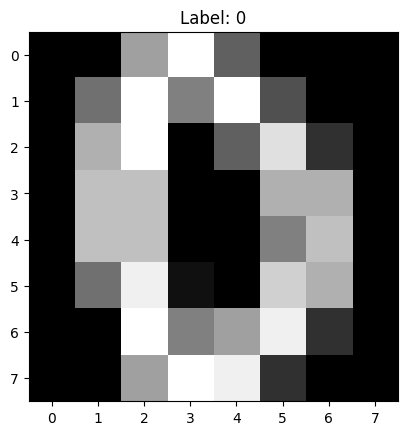

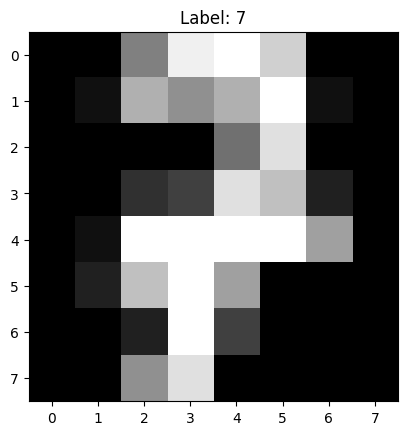

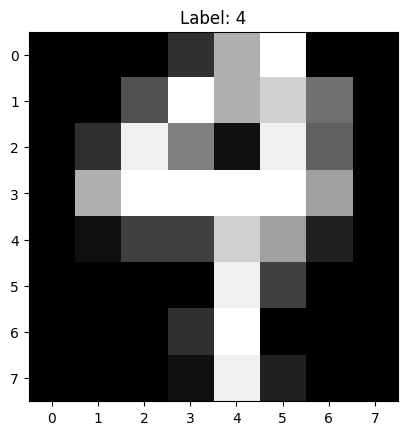

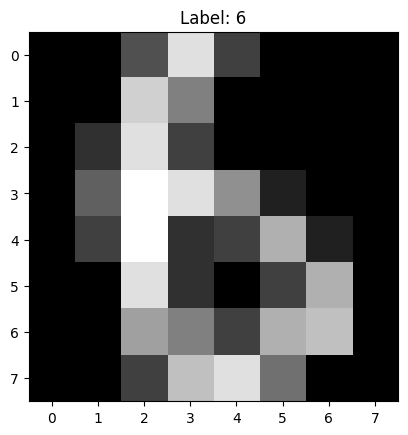

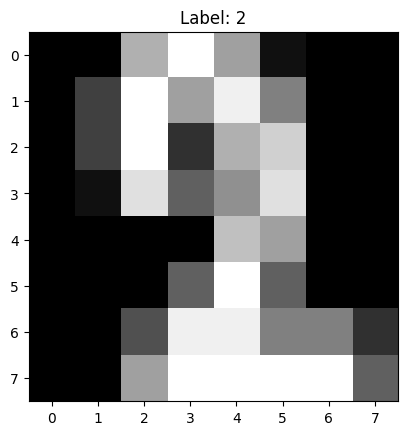

In [9]:
# call the show_digit function for the first five rows of the train dataset 
for i in range(5):
    show_digit(train_data.iloc[:, :-1].values[i], train_data.iloc[:, -1].values[i])

# Data Preprocessing 

> The previous datasets are split into the X features and y labels for both the training and testing datasets.

> The y labels are then mapped or one-hot encoded, the following is an example: <br> 
> If the y label is <b>4</b>, after being mapped/one-hot encoded it would appear as such $ [0,0,0,0,1,0,0,0,0,0] $ , the fourth index is set to 1 and the rest 0.

In [10]:
# the below function is to map the labels or to perform one-hot encoding, it takes the y or target values along with the number of classses
# for example, if the target is 7 -> [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] 
def map_labels(targets, num_classes):
    map = []
    for target in targets:
        row = [0] * num_classes
        row[target] = 1
        map.append(row)
    return np.array(map)

In [12]:
# convert the y target to one-hot encoding for multiclass classification 
# seperate the datasets into train and test X and y's
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values     

# get the number of classes for both train and test targets (they're the same number) 
num_train_classes = len(np.unique(y_train))
num_test_classes = len(np.unique(y_test))

# map both the train and test targets(y) 
y_train_mapped = map_labels(y_train, num_train_classes)
y_test_mapped = map_labels(y_test, num_test_classes)

print(f'normal: {y_train[:5]} \nmapped: {y_train_mapped[:5]} \n')
print(f'number of training samples: {X_train.shape[0]} \nnumber of testing samples {X_test.shape[0]}')

normal: [0 7 4 6 2] 
mapped: [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]] 

number of training samples: 2809 
number of testing samples 2809


# Model Training

> The model is configured with <b>512</b> neurons in the first hidden layer, <b>1024</b> neurons in the second hidden layer, <b>1500</b> cycles, <b>0.001</b> learning rate and <b>0.5</b> dropout rate.

> It is then trained using <b>X_train</b> and <b>y_train_mapped</b>.

In [15]:
# takes the model along with the X and y, makes the predictions with the model and calculates the accuracy
def evaluate_model(model, X, y):
    preds = model.make_prediction(X)
    true_labels = np.argmax(y, axis=1)
    
    correct_preds = np.sum(preds == true_labels)
    accuracy = (correct_preds / len(true_labels)) * 100

    # returns the accuracy, along with the predictions and the true labels 
    return accuracy, preds, true_labels

In [16]:
# takes the parameter grid, along with the X and y's for train and test, it then tries every combination of parameters in the grid
# prints the set of parameters that give the highest accuracy along with the accuracy achieved at the end.
def test_parameters(i, o, parameter_grid, X_train, y_train_mapped, X_test, y_test_mapped):

    # get parameter names and their associated values 
    parameter_names = list(parameter_grid.keys())
    parameter_values = list(parameter_grid.values())

    # the below variables are used to keep track of the best accuracy and parameters across different training cycles 
    best_accuracy = 0
    best_parameters = {}

    # nested for loops for covering each parameter value 
    for h1 in parameter_values[0]:
        for h2 in parameter_values[1]:
            for cycles in parameter_values[2]:
                for learning_rate in parameter_values[3]:
                    for dropout_rate in parameter_values[4]:  

                        # the current params the model will be trained with 
                        cur_parameters = {
                            parameter_names[0]: h1, parameter_names[1]: h2, parameter_names[2]: cycles, parameter_names[3]: learning_rate, parameter_names[4]: dropout_rate
                        }

                        # print the parameters 
                        print(f"testing parameters: {cur_parameters}")

                        # create the model and train it on the train data
                        mlp_model = MLP(i, h1, h2, o, cycles, learning_rate, dropout_rate)
                        mlp_model.train(X_train, y_train_mapped)
                
                        # evaluate training set
                        train_accuracy, _, _ = evaluate_model(mlp_model, X_train, y_train_mapped)
                        print(f"training accuracy: {train_accuracy:.3f}%")
                        
                        # evaluate testing set
                        test_accuracy, _, _ = evaluate_model(mlp_model, X_test, y_test_mapped)
                        print(f"testing accuracy: {test_accuracy:.3f}%")


                        # update the best accuracy if it is lower than the current test accuracy 
                        if test_accuracy > best_accuracy:
                            best_accuracy = test_accuracy
                            best_parameters = cur_parameters

    # print the best parameters and the best accuracy 
    print("\nBest Hyperparameters Found:")
    print(best_parameters)
    print(f"Best Testing Accuracy: {best_accuracy:.2f}%")


In [18]:
# the below grid contains different values for the parameters of the model, the test_parameters function will go through every combination.
test_parameters_grid = {
    'h1': [256, 512, 1024],  
    'h2': [256, 512, 1024], 
    'cycles': [1500],  
    'learning_rate': [0.001], 
    'dropout_rate': [0.5]
}
test_parameters(64, 10, test_parameters_grid, X_train, y_train_mapped, X_test, y_test_mapped)

testing parameters: {'h1': 256, 'h2': 256, 'cycles': 1500, 'learning_rate': 0.001, 'dropout_rate': 0.5}
Cycle: 0, Training Accuracy: 9.292%
Cycle: 10, Training Accuracy: 51.833%
Cycle: 20, Training Accuracy: 73.549%
Cycle: 30, Training Accuracy: 80.064%
Cycle: 40, Training Accuracy: 86.009%
Cycle: 50, Training Accuracy: 88.644%
Cycle: 60, Training Accuracy: 91.064%
Cycle: 70, Training Accuracy: 93.129%
Cycle: 80, Training Accuracy: 93.699%
Cycle: 90, Training Accuracy: 94.446%
Cycle: 100, Training Accuracy: 95.016%
Cycle: 110, Training Accuracy: 95.799%
Cycle: 120, Training Accuracy: 96.547%
Cycle: 130, Training Accuracy: 96.689%
Cycle: 140, Training Accuracy: 97.152%
Cycle: 150, Training Accuracy: 97.188%
Cycle: 160, Training Accuracy: 97.508%
Cycle: 170, Training Accuracy: 98.291%
Cycle: 180, Training Accuracy: 98.113%
Cycle: 190, Training Accuracy: 98.042%
Cycle: 200, Training Accuracy: 97.971%
Cycle: 210, Training Accuracy: 98.683%
Cycle: 220, Training Accuracy: 98.647%
Cycle: 230,

# Two-Fold Test And Evaluation  

> Two models are trained (with the same parameters), the first one is trained on X_train and y_train_mapped and tested on X_test and y_test_mapped, the second mlp model is trained on X_test and y_test_mapped, and tested on X_train and y_train_mapped (the train and test have been swtched for the second model.

> After the training is over, the first model is evaluated by making it predict the y labels for the X_train dataset and comparing it with the y_train_mapped to determine its final accuracy on the training dataset.

> It is also evaluated on its predictions for X_test dataset to see how it performs with unseen data it wasn't explicity trained on to determine the testing accuracy.

> the second model is evaluated by making it predict the y labels for the X_test dataset and comparing it with the y_test_mapped to determine its final accuracy on the training dataset. (keep in mind, the data has been switched for the second model, it is trained on test data and tested on train data)

> It is also evaluated on its predictions for X_train dataset to see how it performs with unseen data it wasn't explicity trained on to determine the testing accuracy.

> The predictions and y labels for both training and testing for the first model are then used to make their respective confusion matrixes and plot it using matplotlib and seaborn.

In [19]:
# initialize the model
mlp_model = MLP(64, 512, 1024, 10, 1500, 0.001, 0.5)

# train the model on the X_train and the one-hot encoded y-train
mlp_model.train(X_train, y_train_mapped)


Cycle: 0, Training Accuracy: 9.149%
Cycle: 10, Training Accuracy: 73.977%
Cycle: 20, Training Accuracy: 85.511%
Cycle: 30, Training Accuracy: 90.424%
Cycle: 40, Training Accuracy: 91.242%
Cycle: 50, Training Accuracy: 94.518%
Cycle: 60, Training Accuracy: 95.906%
Cycle: 70, Training Accuracy: 96.369%
Cycle: 80, Training Accuracy: 96.974%
Cycle: 90, Training Accuracy: 97.615%
Cycle: 100, Training Accuracy: 98.042%
Cycle: 110, Training Accuracy: 98.362%
Cycle: 120, Training Accuracy: 98.078%
Cycle: 130, Training Accuracy: 98.968%
Cycle: 140, Training Accuracy: 98.932%
Cycle: 150, Training Accuracy: 99.502%
Cycle: 160, Training Accuracy: 99.359%
Cycle: 170, Training Accuracy: 99.537%
Cycle: 180, Training Accuracy: 99.359%
Cycle: 190, Training Accuracy: 99.573%
Cycle: 200, Training Accuracy: 99.751%
Cycle: 210, Training Accuracy: 99.430%
Cycle: 220, Training Accuracy: 99.608%
Cycle: 230, Training Accuracy: 99.715%
Cycle: 240, Training Accuracy: 99.822%
Cycle: 250, Training Accuracy: 99.786

In [29]:
# evaluate training set
train_accuracy, mlp_training_predictions, true_first_training_labels = evaluate_model(mlp_model, X_train, y_train_mapped)
print(f"first model training accuracy: {train_accuracy:.3f}%")

# evaluate testing set
test_accuracy, mlp_testing_predictions,  true_first_testing_labels= evaluate_model(mlp_model, X_test, y_test_mapped)
print(f"first model testing accuracy: {test_accuracy:.3f}%")

first model training accuracy: 100.000%
first model testing accuracy: 98.398%


In [21]:
# initialize the model
second_mlp_model = MLP(64, 512, 1024, 10, 1500, 0.001, 0.5)

# train the model on the X_train and the one-hot encoded y-train
second_mlp_model.train(X_test, y_test_mapped)

Cycle: 0, Training Accuracy: 8.117%
Cycle: 10, Training Accuracy: 69.491%
Cycle: 20, Training Accuracy: 83.339%
Cycle: 30, Training Accuracy: 89.035%
Cycle: 40, Training Accuracy: 91.598%
Cycle: 50, Training Accuracy: 93.414%
Cycle: 60, Training Accuracy: 94.660%
Cycle: 70, Training Accuracy: 95.977%
Cycle: 80, Training Accuracy: 97.045%
Cycle: 90, Training Accuracy: 96.582%
Cycle: 100, Training Accuracy: 98.256%
Cycle: 110, Training Accuracy: 98.327%
Cycle: 120, Training Accuracy: 98.540%
Cycle: 130, Training Accuracy: 98.256%
Cycle: 140, Training Accuracy: 99.074%
Cycle: 150, Training Accuracy: 99.039%
Cycle: 160, Training Accuracy: 99.003%
Cycle: 170, Training Accuracy: 99.359%
Cycle: 180, Training Accuracy: 99.466%
Cycle: 190, Training Accuracy: 99.252%
Cycle: 200, Training Accuracy: 99.608%
Cycle: 210, Training Accuracy: 99.502%
Cycle: 220, Training Accuracy: 99.893%
Cycle: 230, Training Accuracy: 99.822%
Cycle: 240, Training Accuracy: 99.786%
Cycle: 250, Training Accuracy: 99.858

In [30]:
# evaluate training set
train_accuracy, second_mlp_training_predictions, true_second_training_labels = evaluate_model(second_mlp_model, X_test, y_test_mapped)
print(f"second model training accuracy: {train_accuracy:.3f}%")

# evaluate testing set
test_accuracy, second_mlp_testing_predictions, true_second_testing_labels = evaluate_model(second_mlp_model, X_train, y_train_mapped)
print(f"second model testing accuracy: {test_accuracy:.3f}%")

second model training accuracy: 100.000%
second model testing accuracy: 98.505%


In [25]:
# takes the actual values, predicted values, and the classes to create a confusion matrix and returns the same 
def confusion_matrix(actual, predicted, classes):
    # create a matrix of zeroes with the same shape as the number of classes (10 classes its shape would be 10x10)
    confmat = np.zeros((len(classes), len(classes)))

    # populate the matrix with a nested for loop
    for i in range(len(classes)):
        for j in range(len(classes)):
            confmat[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return confmat

# plots the confusion matrix provided by the confusion_matrix function using matplotlib and seaborn
def plot_confusion_matrix(confmat, classes, title="Confusion Matrix"):
   
    plt.figure(figsize=(8, 6))
    sns.heatmap(confmat, annot=True, fmt="g", cmap="Purples", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


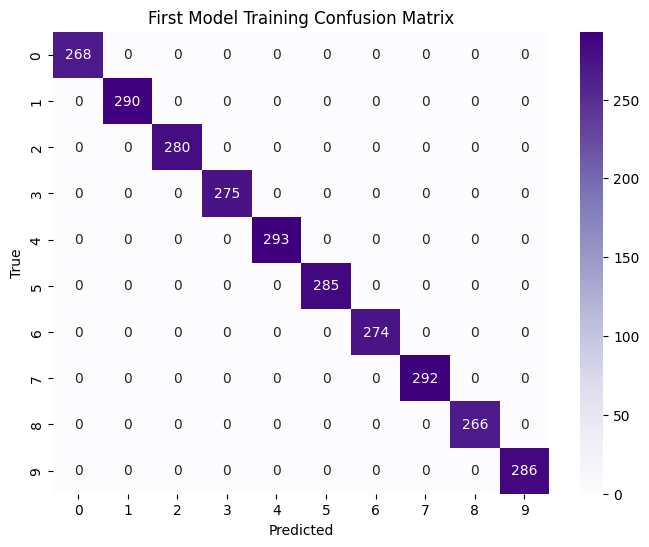

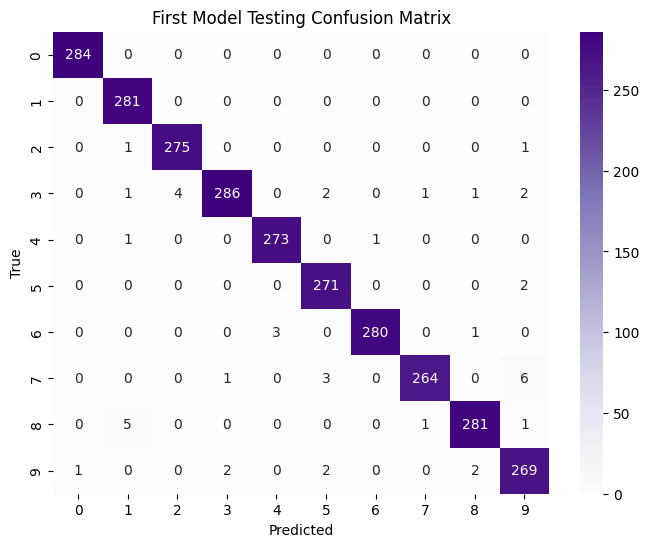

In [32]:
# define the classes 
classes = np.unique(true_training_labels) 

# confusion matrix for training data
first_training_confmat = confusion_matrix(true_first_training_labels, mlp_training_predictions, classes)

# confusion matrix for testing data
first_testing_confmat = confusion_matrix(true_first_testing_labels, mlp_testing_predictions, classes)

# plot the training confusion matrixfor the first mlp model
plot_confusion_matrix(first_training_confmat, classes, title="First Model Training Confusion Matrix")

# plot the testing confusion matrix for the first mlp model
plot_confusion_matrix(first_testing_confmat, classes, title="First Model Testing Confusion Matrix")
